# SHAP feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [43]:
n_folds = 5 # this sets global setting of which how many bootstraps to use
n_hold_out = 0#1
repeats = 10
importance_type = "split"
display_genes = 15

life_history = ["lifespan", "mass_kg", "mtGC", "metabolic_rate", "temperature", "gestation_days"]
trait = "lifespan"
stage_num = 2
opt_metrics = "huber"
debug_local = True #to use local version

In [44]:
from pathlib import Path
import sys
import inspect

#lgb_params["importance_type"] = importance_type

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '..', '..', '/data/sources/yspecies/notebooks', '/data/miniconda3/envs/yspecies/lib/python38.zip', '/data/miniconda3/envs/yspecies/lib/python3.8', '/data/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import TupleWith, Repeat, Collect
from yspecies.config import *
from yspecies.preprocess import FeatureSelection, DataExtractor
from yspecies.partition import DataPartitioner, PartitionParameters
from yspecies.models import Metrics

In [47]:
import optuna
from optuna import Study, Trial
from optuna import multi_objective
from optuna.multi_objective import trial
from optuna.multi_objective.study import MultiObjectiveStudy
from yspecies.tuning import MultiObjectiveResults

In [48]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import pprint
pp = pprint.PrettyPrinter(indent=4)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: agg


### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [49]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

In [50]:
from loguru import logger
logger.add(locations.logs / "stage_two_shap_selection.log", rotation="12:00")     # New file is created each day at noon

3

In [51]:
suffix=f"_{stage_num}"
stage_2_folder = locations.interim.dir / f"stage{suffix}" 
stage_2_folder.mkdir(exist_ok=True)
partitions_folder = stage_2_folder  / "partitions"
partitions_folder.mkdir(exist_ok=True)

In [52]:
data = ExpressionDataset.from_folder(locations.interim.dir / f"stage{suffix}" / "input")
data

<table border='2'><caption>input<caption><tr><th>expressions</th><th>genes</th><th>species</th><th>samples</th><th>Genes Metadata</th><th>Species Metadata</th></tr><tr><td>(408, 154)</td><td>(154, 37)</td><td>38</td><td>408</td><td>(154, 2)</td><td>(38, 18)</td></tr></table>

## Setting up features to select ##

In [53]:
default_selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"],
    select_by = "shap",
    importance_type =  importance_type,
    feature_perturbation = "tree_path_dependent"
)
default_selection

FeatureSelection(samples=['tissue', 'species'], species=[], genes=None, to_predict='lifespan', categorical=['tissue'], exclude_from_training=['species'], genes_meta=None, select_by='shap', importance_type='split', feature_perturbation='tree_path_dependent', not_validated_species=[])

In [54]:
selections = OrderedDict([(trait, (data,  replace(default_selection, to_predict = trait, not_validated_species = data.min_max_trait(trait) ))) for trait in life_history])
selections[trait][0]

<table border='2'><caption>input<caption><tr><th>expressions</th><th>genes</th><th>species</th><th>samples</th><th>Genes Metadata</th><th>Species Metadata</th></tr><tr><td>(408, 154)</td><td>(154, 37)</td><td>38</td><td>408</td><td>(154, 2)</td><td>(38, 18)</td></tr></table>

### Setting up pipelines ###

In [55]:
from yspecies.helpers import PipelineFactory
factory = PipelineFactory(locations,repeats, n_folds, n_hold_out)
validation_factory = PipelineFactory(locations,repeats, n_folds, n_hold_out+1)

In [56]:
validation_factory = PipelineFactory(locations,repeats, n_folds-1, n_hold_out+1)

In [57]:
def opt_by_trait(trait: str, suffix: str = ""):
    return locations.interim.optimization / f"{trait}{suffix}.sqlite"

In [58]:
lifespan_pipeline = factory.make_repeated_shap_pipeline(study_path = opt_by_trait(trait, suffix), study_name=f"{trait}_r2_huber_kendall", opt_metrics=opt_metrics)
lifespan_pipeline

loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan_2.sqlite


create_study is experimental (supported from v1.4.0). The interface can change in the future.
NSGAIIMultiObjectiveSampler is experimental (supported from v1.5.0). The interface can change in the future.
RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.
[I 2020-12-15 10:59:00,756] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.
MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.


Pipeline(steps=[('extractor', DataExtractor()),
                ('prepare_for_partitioning',
                 TupleWith(parameters=PartitionParameters(n_folds=5, n_hold_out=0, species_in_validation=2, seed=42), map_left=<function TupleWith.<lambda>.<locals>.<lambda> at 0x7fe6fcfd2c10>, map_right=<function TupleWith.<lambda>.<locals>.<lambda> at 0x7fe6fcfd28b0>)),
                ('repeated_partition_shap',
                 Repea...
                 CrossValidator(early_stopping_rounds=10, models=[], evals=[])),
                ('shap_computation', ShapSelector())]), repeats=10, map=<function PipelineFactory.make_repeated_shap_pipeline.<locals>.<lambda> at 0x7fe6fcfd2280>)),
                ('summarize',
                 Collect(fold=<function PipelineFactory.make_repeated_shap_pipeline.<locals>.<lambda> at 0x7fe6fcfd2430>, filter=<function Collect.<lambda>.<locals>.<lambda> at 0x7fe6fcfd2790>))])

In [59]:
#for debug purposes
stl = StudyLoader(locations)
s = stl.load_study(trait, f"lifespan{suffix}")
study_results = MultiObjectiveResults.from_study(s)
study_results.best_metrics_params_huber(False)
# 0.9349349119232961, 2.9362308531247434, 0.5040305333344755

create_study is experimental (supported from v1.4.0). The interface can change in the future.
[I 2020-12-15 10:59:35,315] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan_2.sqlite


((0.9308264361533223, 2.8757669652865037, 0.48513215430346185),
 {'bagging_fraction': 0.3894297532715532,
  'boosting_type': 'gbdt',
  'drop_rate': 0.26800128097507525,
  'feature_fraction': 0.40928196640627,
  'lambda_l1': 1.5344719775574764,
  'lambda_l2': 2.4063980152266398,
  'learning_rate': 0.044493898644234905,
  'max_depth': 4,
  'max_leaves': 22,
  'min_data_in_leaf': 4,
  'objective': 'regression',
  'metrics': ['l1', 'l2', 'huber']})

In [60]:
study_results.best_metrics_params_r2(False)

((0.9370343134614976, 2.919847455607666, 0.4955566962825312),
 {'bagging_fraction': 0.3894297532715532,
  'boosting_type': 'gbdt',
  'drop_rate': 0.28352543078856607,
  'feature_fraction': 0.40928196640627,
  'lambda_l1': 0.5753490561144472,
  'lambda_l2': 2.4063980152266398,
  'learning_rate': 0.09567898716836132,
  'max_depth': 3,
  'max_leaves': 23,
  'min_data_in_leaf': 8,
  'objective': 'regression',
  'metrics': ['l1', 'l2', 'huber']})

## Computing stage II results ##

In [61]:
lifespan_results = lifespan_pipeline.fit_transform(selections["lifespan"])
print(lifespan_results.metrics_average)
lifespan_results.selected

2020-12-15 10:59:43.117 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-12-15 10:59:43.183 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-12-15 10:59:43.304 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[236]	valid_0's l1: 5.50165	valid_0's l2: 98.6226	valid_0's huber: 4.62393


2020-12-15 11:01:05.872 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:02:13.651 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Early stopping, best iteration is:
[205]	valid_0's l1: 2.84717	valid_0's l2: 38.7861	valid_0's huber: 2.23182
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:03:11.416 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Early stopping, best iteration is:
[166]	valid_0's l1: 3.01852	valid_0's l2: 29.8965	valid_0's huber: 2.39487
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:04:41.814 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


[250]	valid_0's l1: 2.56494	valid_0's l2: 32.54	valid_0's huber: 1.9978
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 2.56494	valid_0's l2: 32.54	valid_0's huber: 1.9978
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[154]	valid_0's l1: 2.21298	valid_0's l2: 15.5669	valid_0's huber: 1.68111


2020-12-15 11:05:52.295 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9418876126070248, MAE=3.2290527324032263, MSE=43.082391760221114, huber=2.5840635802836602)
2020-12-15 11:05:52.308 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-12-15 11:05:52.310 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-12-15 11:05:52.327 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argumen

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:06:28.724 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Early stopping, best iteration is:
[196]	valid_0's l1: 2.80167	valid_0's l2: 26.8374	valid_0's huber: 2.20504
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:07:11.519 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[228]	valid_0's l1: 3.70129	valid_0's l2: 50.845	valid_0's huber: 3.01759
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:08:01.364 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 2.45694	valid_0's l2: 21.0151	valid_0's huber: 1.8819
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 2.45694	valid_0's l2: 21.0151	valid_0's huber: 1.8819
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:08:52.878 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 3.96372	valid_0's l2: 68.3444	valid_0's huber: 3.25063
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 3.96338	valid_0's l2: 68.3104	valid_0's huber: 3.25002
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 2.34942	valid_0's l2: 22.4323	valid_0's huber: 1.82572
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 2.34907	valid_0's l2: 22.4173	valid_0's huber: 1.82529


2020-12-15 11:10:20.632 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9464980568759632, MAE=3.054467963046323, MSE=37.88504881940416, huber=2.4349741927567323)
2020-12-15 11:10:20.646 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-12-15 11:10:20.648 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-12-15 11:10:20.670 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of a

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:11:06.596 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


[250]	valid_0's l1: 2.52962	valid_0's l2: 21.5664	valid_0's huber: 1.94868
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 2.52925	valid_0's l2: 21.5722	valid_0's huber: 1.94898
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:11:46.373 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[206]	valid_0's l1: 2.78087	valid_0's l2: 21.1268	valid_0's huber: 2.1497
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:12:30.440 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Early stopping, best iteration is:
[227]	valid_0's l1: 3.24291	valid_0's l2: 38.7018	valid_0's huber: 2.58751
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:13:19.678 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


[250]	valid_0's l1: 4.99407	valid_0's l2: 78.4679	valid_0's huber: 4.14799
Did not meet early stopping. Best iteration is:
[247]	valid_0's l1: 4.99304	valid_0's l2: 78.4586	valid_0's huber: 4.14707
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	valid_0's l1: 2.29898	valid_0's l2: 27.6491	valid_0's huber: 1.73708


2020-12-15 11:14:29.870 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9369706849955526, MAE=3.1690083379836467, MSE=37.501703985547465, huber=2.514238676761487)
2020-12-15 11:14:29.882 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-12-15 11:14:29.883 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-12-15 11:14:29.921 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argum

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:15:09.138 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[207]	valid_0's l1: 2.77763	valid_0's l2: 29.2662	valid_0's huber: 2.17968
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:15:48.291 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Early stopping, best iteration is:
[205]	valid_0's l1: 5.23397	valid_0's l2: 72.9049	valid_0's huber: 4.38582
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:16:39.238 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


[250]	valid_0's l1: 2.61299	valid_0's l2: 16.4961	valid_0's huber: 2.03341
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 2.61299	valid_0's l2: 16.4961	valid_0's huber: 2.03341
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:17:32.331 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


[250]	valid_0's l1: 2.0676	valid_0's l2: 42.2018	valid_0's huber: 1.55307
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 2.0676	valid_0's l2: 42.2018	valid_0's huber: 1.55307
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[171]	valid_0's l1: 2.32419	valid_0's l2: 25.1408	valid_0's huber: 1.76924


2020-12-15 11:18:46.841 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9458781417912208, MAE=3.003274507306146, MSE=37.201945285594974, huber=2.3841830815397933)
2020-12-15 11:18:46.852 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-12-15 11:18:46.854 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-12-15 11:18:46.870 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of a

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:19:25.051 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Early stopping, best iteration is:
[203]	valid_0's l1: 2.64104	valid_0's l2: 28.1379	valid_0's huber: 2.07751
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:20:04.245 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Early stopping, best iteration is:
[218]	valid_0's l1: 2.70823	valid_0's l2: 29.1908	valid_0's huber: 2.12883
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:20:55.797 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


[250]	valid_0's l1: 3.63438	valid_0's l2: 33.7524	valid_0's huber: 2.95439
Did not meet early stopping. Best iteration is:
[246]	valid_0's l1: 3.63337	valid_0's l2: 33.7422	valid_0's huber: 2.95434
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:21:46.787 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 5.04657	valid_0's l2: 95.2094	valid_0's huber: 4.2379
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 5.04657	valid_0's l2: 95.2094	valid_0's huber: 4.2379
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[137]	valid_0's l1: 2.17505	valid_0's l2: 26.6487	valid_0's huber: 1.64882


2020-12-15 11:22:54.768 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9406931187687615, MAE=3.2408519532821303, MSE=42.58579732841012, huber=2.6100581259202458)
2020-12-15 11:22:54.778 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-12-15 11:22:54.780 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-12-15 11:22:54.798 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:23:38.793 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


[250]	valid_0's l1: 2.15202	valid_0's l2: 10.9432	valid_0's huber: 1.61461
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 2.15172	valid_0's l2: 10.9459	valid_0's huber: 1.61448
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:24:23.357 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 2.53772	valid_0's l2: 23.4285	valid_0's huber: 1.96393
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 2.53772	valid_0's l2: 23.4285	valid_0's huber: 1.96393
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:25:19.397 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 5.5674	valid_0's l2: 104.331	valid_0's huber: 4.6814
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 5.5674	valid_0's l2: 104.331	valid_0's huber: 4.6814
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:26:11.625 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


[250]	valid_0's l1: 2.97728	valid_0's l2: 41.144	valid_0's huber: 2.38321
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 2.97728	valid_0's l2: 41.144	valid_0's huber: 2.38321
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[231]	valid_0's l1: 2.20499	valid_0's l2: 20.7835	valid_0's huber: 1.68532


2020-12-15 11:27:37.569 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9446259314176502, MAE=3.087822228968086, MSE=40.12648236188332, huber=2.465537325287602)
2020-12-15 11:27:37.583 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-12-15 11:27:37.584 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-12-15 11:27:37.592 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it in

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:28:20.231 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Early stopping, best iteration is:
[211]	valid_0's l1: 2.15853	valid_0's l2: 13.4796	valid_0's huber: 1.64914
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:28:56.983 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Early stopping, best iteration is:
[194]	valid_0's l1: 2.6771	valid_0's l2: 28.1774	valid_0's huber: 2.08835
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:29:47.518 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 2.46702	valid_0's l2: 23.5589	valid_0's huber: 1.90474
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 2.4661	valid_0's l2: 23.558	valid_0's huber: 1.90438
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:30:33.611 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


Early stopping, best iteration is:
[234]	valid_0's l1: 3.77219	valid_0's l2: 53.23	valid_0's huber: 3.06673
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's l1: 2.4432	valid_0's l2: 35.9812	valid_0's huber: 1.90275


2020-12-15 11:31:48.113 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9549462687240053, MAE=2.703420593638554, MSE=30.885248045175473, huber=2.1206048604983514)
2020-12-15 11:31:48.125 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-12-15 11:31:48.127 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-12-15 11:31:48.143 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argume

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:32:29.459 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Early stopping, best iteration is:
[211]	valid_0's l1: 2.44123	valid_0's l2: 15.0117	valid_0's huber: 1.85611
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:32:53.510 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Early stopping, best iteration is:
[136]	valid_0's l1: 2.92324	valid_0's l2: 36.4202	valid_0's huber: 2.30299
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:33:46.600 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 3.05156	valid_0's l2: 24.838	valid_0's huber: 2.41616
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 3.05082	valid_0's l2: 24.8232	valid_0's huber: 2.41552
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:34:31.035 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[199]	valid_0's l1: 2.79448	valid_0's l2: 54.4979	valid_0's huber: 2.22696
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 1.69566	valid_0's l2: 13.3504	valid_0's huber: 1.23563
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 1.69561	valid_0's l2: 13.3476	valid_0's huber: 1.23549


2020-12-15 11:35:55.417 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9592981851472068, MAE=2.5810769189354335, MSE=28.820113059316704, huber=2.006778881459409)
2020-12-15 11:35:55.428 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-12-15 11:35:55.430 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-12-15 11:35:55.438 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argum

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:36:25.771 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Early stopping, best iteration is:
[163]	valid_0's l1: 2.51254	valid_0's l2: 16.1553	valid_0's huber: 1.93405
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:37:09.979 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Early stopping, best iteration is:
[213]	valid_0's l1: 1.93113	valid_0's l2: 12.415	valid_0's huber: 1.42945
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:37:58.773 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


[250]	valid_0's l1: 2.87563	valid_0's l2: 21.9009	valid_0's huber: 2.25928
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 2.8744	valid_0's l2: 21.8974	valid_0's huber: 2.25826
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:38:50.655 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


[250]	valid_0's l1: 2.53168	valid_0's l2: 39.7099	valid_0's huber: 1.99436
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 2.53168	valid_0's l2: 39.7099	valid_0's huber: 1.99436
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[122]	valid_0's l1: 3.00798	valid_0's l2: 39.3753	valid_0's huber: 2.39899


2020-12-15 11:39:55.083 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9613578952833018, MAE=2.571546335782318, MSE=25.9105871219404, huber=2.0031846459610607)
2020-12-15 11:39:55.096 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-12-15 11:39:55.098 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.3894297532715532, 'boosting_type': 'gbdt', 'drop_rate': 0.26800128097507525, 'feature_fraction': 0.40928196640627, 'lambda_l1': 1.5344719775574764, 'lambda_l2': 2.4063980152266398, 'learning_rate': 0.044493898644234905, 'max_depth': 4, 'max_leaves': 22, 'min_data_in_leaf': 4, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-12-15 11:39:55.109 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:40:35.657 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[212]	valid_0's l1: 2.30012	valid_0's l2: 13.209	valid_0's huber: 1.7664
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:41:02.164 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Early stopping, best iteration is:
[132]	valid_0's l1: 4.7496	valid_0's l2: 61.6169	valid_0's huber: 3.93718
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:41:49.650 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


[250]	valid_0's l1: 3.90004	valid_0's l2: 35.0529	valid_0's huber: 3.17894
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 3.90004	valid_0's l2: 35.0529	valid_0's huber: 3.17894
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-12-15 11:42:39.764 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 4.68859	valid_0's l2: 87.3639	valid_0's huber: 3.89807
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 4.68859	valid_0's l2: 87.3639	valid_0's huber: 3.89807
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[197]	valid_0's l1: 2.9155	valid_0's l2: 23.3791	valid_0's huber: 2.30604


2020-12-15 11:43:55.024 | INFO     | yspecies.explanations:transform:741 - Metrics: 
Metrics(R2=0.9377651082893737, MAE=3.71077027271617, MSE=44.124368545383206, huber=3.0170174010883337)


Metrics(R2=0.9469921003900061, MAE=3.0351291844062036, MSE=36.8123686312877, huber=2.4140640771556674)


symbol  repeats  mean_abs_shap  mean_kendall_tau  shap_0  \
ENSG00000010219     DYRK4   10.000          3.178             0.357   2.747   
ENSG00000204498   NFKBIL1   10.000          2.261            -0.476   2.231   
ENSG00000167515  TRAPPC2L   10.000          2.231            -0.342   2.310   
ENSG00000105672      ETV2   10.000          1.197             0.682   1.407   
ENSG00000106554    CHCHD3   10.000          1.076            -0.510   0.641   
ENSG00000066923     STAG3   10.000          0.922             0.495   0.866   
ENSG00000170835       CEL   10.000          0.849             0.746   0.814   
ENSG00000185880    TRIM69   10.000          0.785            -0.120   0.594   
ENSG00000092529     CAPN3   10.000          0.719             0.580   1.124   
ENSG00000171121    KCNMB3   10.000          0.669             0.624   0.556   
ENSG00000132436    FIGNL1   10.000          0.552             0.534   0.631   
ENSG00000188747     NOXA1   10.000          0.507             0.697   0.385   
ENSG00000013288    MAN2B2   10.000          0.492            -0.655   0.607   
ENSG00000157343    ARMC12   10.000          0.488             0.587   0.435   
ENSG00000134489      HRH4   10.000          0.448             0.606   0.364   
ENSG00000144451    SPAG16   10.000          0.428             0.597   0.375   
ENSG00000023191      RNH1   10.000          0.395            -0.550   0.425   
ENSG00000142541    RPL13A   10.000          0.371            -0.017   0.340   
ENSG00000165501      LRR1   10.000          0.366             0.715   0.394   
ENSG00000160948     VPS28   10.000          0.362            -0.582   0.450   
ENSG00000183864      TOB2   10.000          0.346             0.256   0.494   
ENSG00000137343     ATAT1   10.000          0.339            -0.581   0.432   
ENSG00000162959     MEMO1   10.000          0.331            -0.609   0.371   
ENSG00000137411     VARS2   10.000          0.317            -0.715   0.339   
ENSG00000006282   SPATA20   10.000          0.311             0.649   0.268   
ENSG00000142002      DPP9   10.000          0.309            -0.717   0.276   
ENSG00000136436  CALCOCO2   10.000          0.307             0.763   0.343   
ENSG00000102265     TIMP1   10.000          0.283             0.633   0.242   
ENSG00000066926      FECH   10.000          0.283            -0.568   0.257   
ENSG00000204231      RXRB   10.000          0.271            -0.534   0.271   
ENSG00000164362      TERT   10.000          0.271            -0.599   0.262   
ENSG00000129187      DCTD   10.000          0.253             0.674   0.289   
ENSG00000152705  CATSPER3   10.000          0.241             0.695   0.290   
ENSG00000165555   NOXRED1   10.000          0.232             0.781   0.221   
ENSG00000198663   C6orf89   10.000          0.226            -0.788   0.196   
ENSG00000122034     GTF3A   10.000          0.220             0.594   0.337   
ENSG00000140398     NEIL1   10.000          0.219             0.788   0.187   
ENSG00000164879       CA3   10.000          0.195            -0.514   0.304   
ENSG00000269058     CALR3   10.000          0.181            -0.615   0.146   
ENSG00000122952     ZWINT   10.000          0.169            -0.634   0.142   
ENSG00000172531    PPP1CA   10.000          0.165            -0.782   0.199   
ENSG00000182612   TSPAN10   10.000          0.157             0.451   0.174   
ENSG00000213719     CLIC1   10.000          0.155            -0.479   0.068   
ENSG00000143443   C1orf56   10.000          0.153             0.732   0.135   
ENSG00000120992    LYPLA1   10.000          0.153            -0.640   0.188   
ENSG00000211454     AKR7L   10.000          0.150            -0.254   0.241   
ENSG00000203710       CR1   10.000          0.146            -0.621   0.124   
ENSG00000135845      PIGC   10.000          0.141             0.159   0.136   
ENSG00000154485     MMP21   10.000          0.141             0.624   0.130   
ENSG00000142937      RPS8   10.000          0.138             0.635  

## evaluate metrics ###

In [64]:
lifespan_results.metrics_average

Metrics(R2=0.9469921003900061, MAE=3.0351291844062036, MSE=36.8123686312877, huber=2.4140640771556674)

## Check plots ##

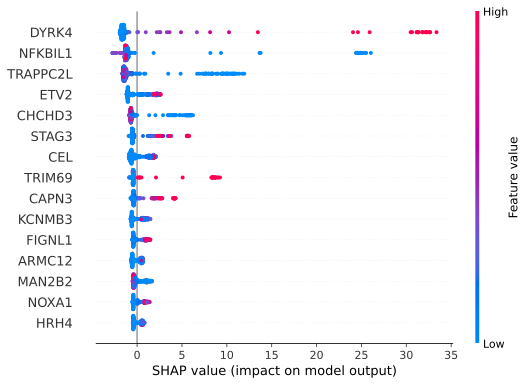

In [361]:
summary_stage_two_plot_path = locations.output.dir / "plots" / f"stage_{stage_num}" / "summary_lifespan.svg"
lifespan_results.plot(title = "second stage lifespan model", max_display=display_genes, plot_size=0.3, save=summary_stage_two_plot_path )

min_max dataset values: (3.3, 122.5)


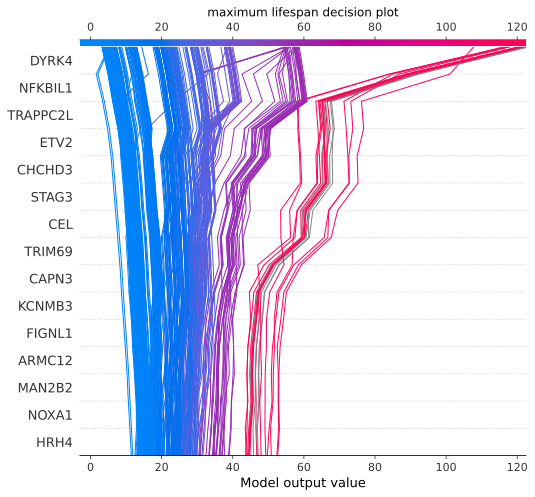

In [367]:
stage_two_decision_plot_path = locations.output.dir / "plots" / f"stage_{stage_num}" / "decision_lifespan.svg"
lifespan_results.plot_decision(save = stage_two_decision_plot_path , title = "maximum lifespan decision plot", minimum = -3, maximum=120, auto_size_plot=(1000,1000), feature_display_range=slice(-1, -display_genes-1, -1))

In [381]:
lifespan_results.partitions.X.shape

(408, 155)

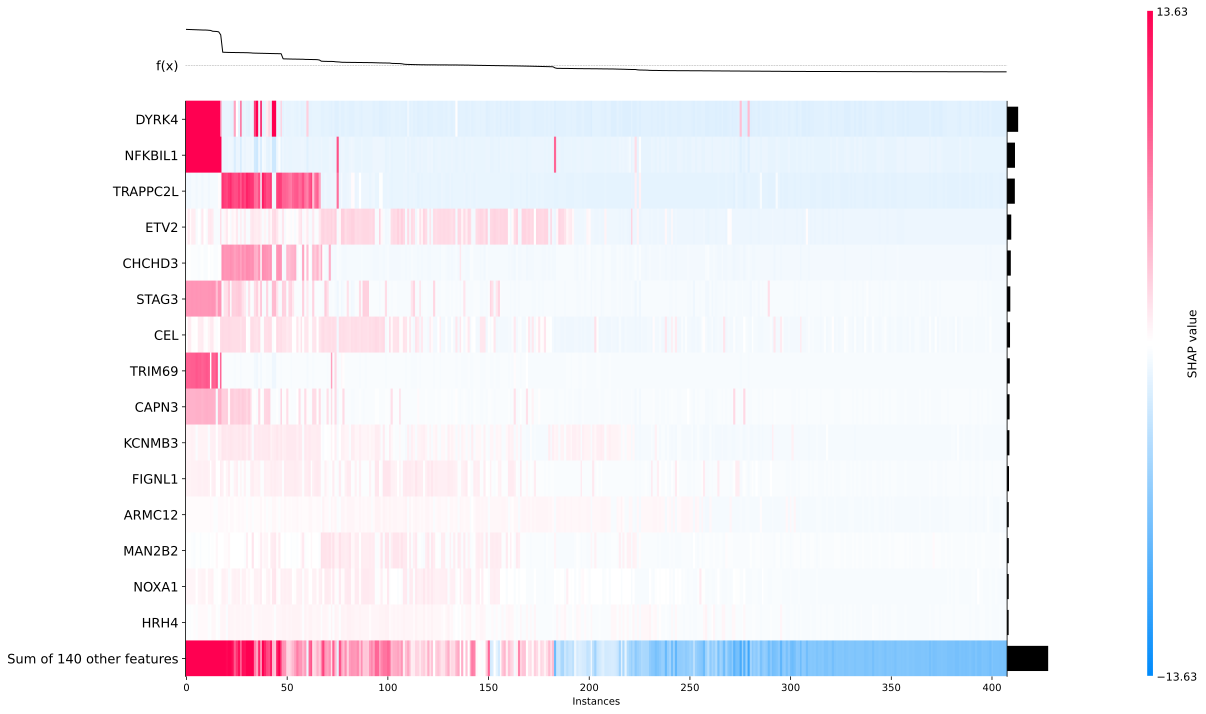

In [373]:
heatmap_stage_two_plot_path = locations.output.plots / f"stage_{stage_num}" / "heatmap_lifespan_unclustered.svg"
lifespan_results.plot_heatmap(True, max_display = display_genes+1, figsize = (24,12), sort_by_clust=False, save = heatmap_stage_two_plot_path)

### Interaction plot ###

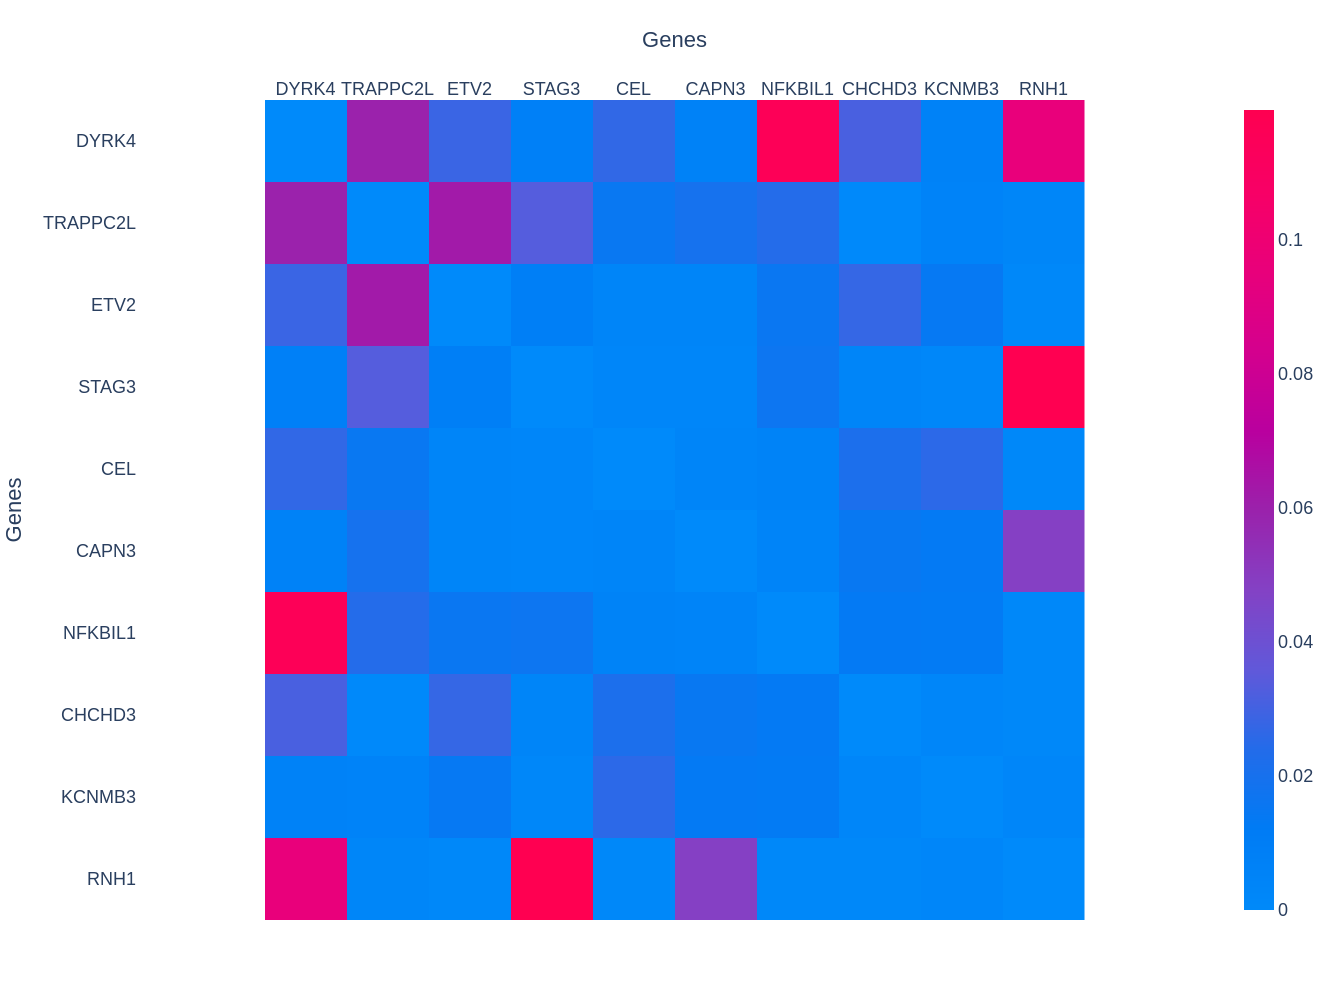

In [81]:
import plotly.io as pio
#pio.orca.config.use_xvfb = True

interactions_stage_two_plot_path = locations.output.plots / "genetic_interactions_stage_two.svg"
from yspecies.explanations import *
lifespan_results.plot_interactions(height=1000, width=1090, max=10-1, title="", axis_title="Genes", font)

### Dependency plots for the most interesting interactions ###

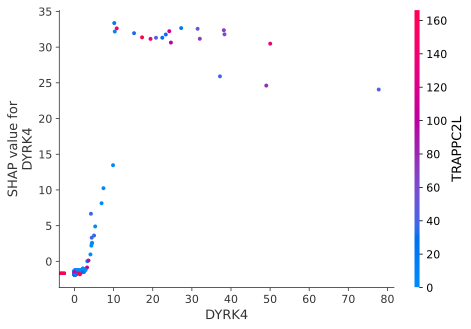

In [68]:
lifespan_results.plot_dependency("DYRK4", "TRAPPC2L", save=locations.output.plots / "interactions" / "DYRK4_TRAPPC2L.svg")

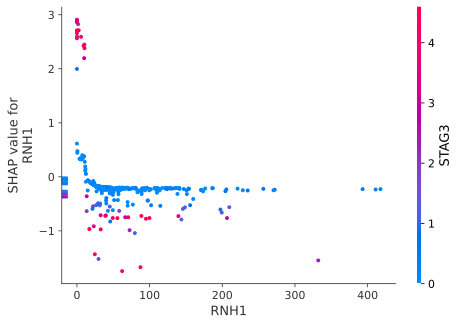

In [151]:
interaction_1 = locations.output.plots / "interactions" / "RNH1_STAG3.svg"
lifespan_results.plot_dependency("RNH1", "STAG3", save=interaction_1)

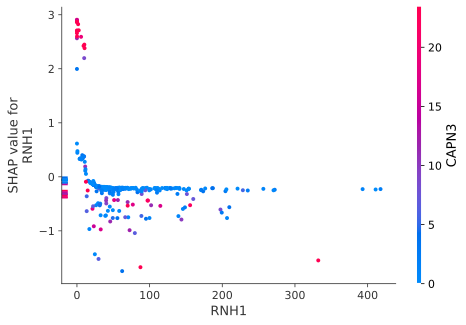

In [152]:
interaction_2 = locations.output.plots / "interactions" / "RNH1_CAPN3.svg"
lifespan_results.plot_dependency("RNH1", "CAPN3", interaction_2)

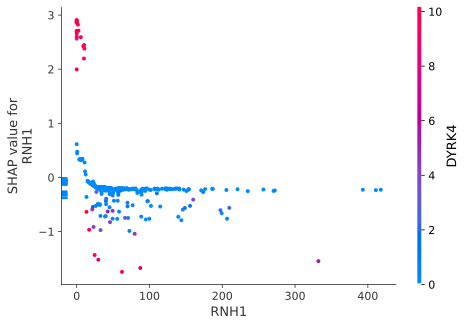

In [70]:
lifespan_results.plot_dependency("RNH1", "DYRK4", save=locations.output.plots / "interactions" / "RNH1_DYRK4.svg")

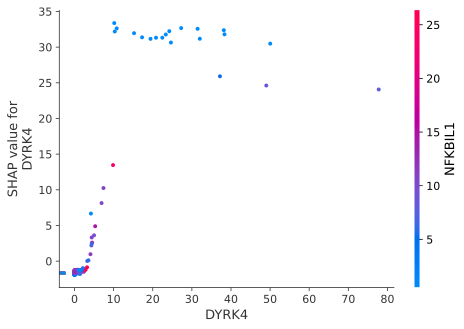

In [153]:
interaction_3 = locations.output.plots / "interactions" / "DYRK4_NFKBIL1.svg"
lifespan_results.plot_dependency("DYRK4", "NFKBIL1", interaction_3)

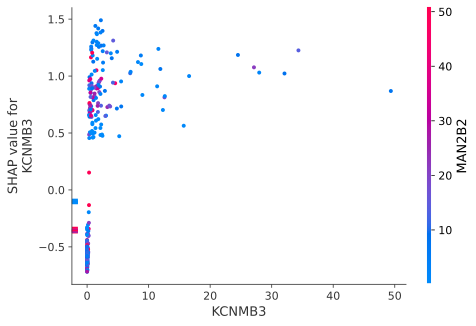

In [73]:
lifespan_results.plot_dependency("KCNMB3", "MAN2B2", locations.output.plots / "interactions" / "KCNMB3_MAN2B2.svg")                                 

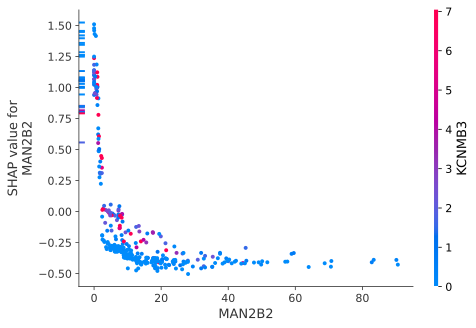

In [74]:
lifespan_results.plot_dependency("MAN2B2","KCNMB3", locations.output.plots / "interactions" / "MAN2B2_KCNMB3.svg")                                 

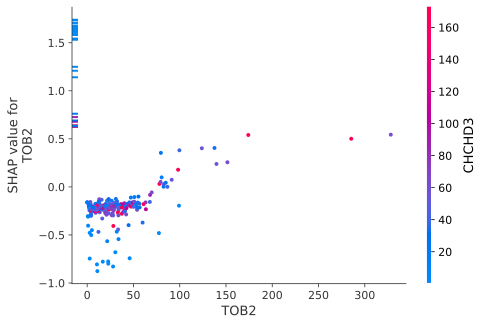

In [71]:
lifespan_results.plot_dependency("TOB2", "CHCHD3", locations.output.plots / "interactions" / "TOB2_CHCHD3.svg")

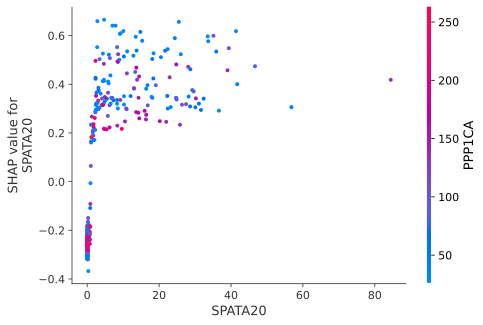

In [41]:
lifespan_results.plot_dependency("SPATA20", "PPP1CA")

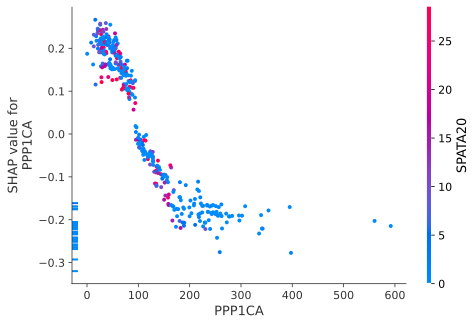

In [42]:
lifespan_results.plot_dependency("PPP1CA", "SPATA20")

##### Extracting raw SHAP values #####

In [359]:
lifespan_results.stable_shap_dataframe.to_csv(locations.output.stage_two / "shap.tsv", sep="\t")
lifespan_results.stable_shap_dataframe_named.to_csv(locations.output.stage_two / "shap_named.tsv", sep="\t")
print(lifespan_results.stable_shap_dataframe_named.shape)
lifespan_results.stable_shap_dataframe_named.head()


(408, 155)


DYRK4  NFKBIL1  TRAPPC2L   CEL   ETV2  TRIM69  STAG3  FIGNL1  \
run                                                                        
SRR5961830 31.317   24.533    -0.554 0.977  0.028   8.649  5.552   0.878   
SRR5885325 31.311   24.875    -0.566 1.094  1.321   0.310  5.578  -0.060   
SRR306843  32.624   25.119    -0.846 0.096 -0.434   8.975  5.722   0.800   
SRR306844   6.667   24.904    -0.625 1.820  1.843   8.391  5.724   0.958   
SRR306845  30.640   24.637    -0.781 1.160  1.277   8.360  5.580   0.809   

            NOXA1  MAN2B2   LRR1  KCNMB3  NOXRED1  RNH1   DPP9  CHCHD3  \
run                                                                      
SRR5961830  0.591  -0.172  0.771   0.733    0.448 2.865  0.183  -0.338   
SRR5885325  0.726   0.043  0.003   0.788    0.247 2.599  0.227  -0.301   
SRR306843   0.067  -0.180 -0.355  -0.385   -0.216 2.659 -0.143  -0.281   
SRR306844  -0.212   0.056  0.177   0.808   -0.039 2.564  0.201  -0.251   
SRR306845   0.628   0.013  0.120   0.653   -0.131 2.423  0.182  -0.064   

            ARMC12  ATAT1  VARS2   FECH  PPP1CA  TIMP1    CA3  CAPN3   HRH4  \
run                                                                           
SRR5961830   0.265  3.553  3.766 -0.094   0.132 -0.370 -0.031  4.215  0.338   
SRR5885325   0.332  3.445  3.826 -0.091   0.131  0.335 -0.013  4.241 -0.204   
SRR306843    0.281  3.644  3.770 -0.019   0.127  0.277  0.368  4.217 -0.252   
SRR306844    0.349  0.441  4.059  0.249   0.159  0.347 -0.016  4.213  0.489   
SRR306845    0.262  0.550  3.575 -0.009   0.126  0.312 -0.013  4.154 -0.172   

            SPAG16  VPS28   TERT   RXRB  CALCOCO2  DCTD  SPATA20  DNAJC15  \
run                                                                         
SRR5961830   1.935  3.314 -0.096 -0.027     0.339 0.256    0.306   -0.044   
SRR5885325   1.865  3.289  0.477  3.727     0.087 0.253    0.320    0.187   
SRR306843    1.966  3.333 -0.117  3.924     0.028 0.220    0.294    0.176   
SRR306844    1.953  1.923  0.628  4.615     0.339 0.304    0.396    0.237   
SRR306845    1.874  2.299  0.542  3.723     0.070 0.243    0.306    0.190   

            CATSPER3   CR1  RAD51C  TSPAN10  NEIL1  STYXL1   LYG1   CTBS  \
run                                                                        
SRR5961830    -0.019 0.092   0.390    0.372  0.356   0.182  0.056 -0.022   
SRR5885325     0.388 0.090   0.347    0.329  0.328   0.165  0.599 -0.041   
SRR306843     -0.112 0.091   0.394    0.355 -0.005   0.065 -0.031  0.044   
SRR306844      0.198 0.105   0.295    0.476  0.398   0.176  0.655  0.169   
SRR306845     -0.046 0.022   0.412    0.319  0.292   0.155  0.085  0.047   

            TMEM115  OPN3  ATP5F1E  CLIC1   RCL1  TAF15  FGF11  GTF3A  NEIL2  \
run                                                                            
SRR5961830    0.004 0.008    0.821  1.082 -0.013 -0.025 -0.000  0.493  0.253   
SRR5885325    0.015 0.014    0.819  1.151  0.015  0.012  0.002  0.200  0.240   
SRR306843     0.014 0.001    0.790  1.044 -0.000  0.123  0.001  0.002  0.286   
SRR306844     0.015 0.017    0.747  1.109  0.030  0.137  0.006  0.194  0.398   
SRR306845     0.015 0.019    0.802  1.089  0.035  0.039 -0.001  0.520  0.305   

            PCMTD1  POP5  XRCC6  EIF3K  CAGE1  ZWINT   SFR1  LGALS4  TSPAN17  \
run                                                                            
SRR5961830   0.006 0.012  0.066  0.009 -0.024  0.074 -0.009   0.019    0.051   
SRR5885325   0.016 0.012  0.057  0.019  0.134  0.068  0.007   0.018    0.095   
SRR306843   -0.012 0.008  0.063  0.021  0.113  0.026  0.020   0.015    0.021   
SRR306844    0.025 0.016  0.084  0.052  0.123  0.131  0.041   0.033    0.017   
SRR306845    0.022 0.012  0.076  0.010  0.110  0.067  0.007   0.018    0.048   

            RPL22L1  YES1  C12orf73  AKR7L  CHCHD4  ERMAP  CETN1  C1orf56  \
run                                                                         
SRR5961830    0.085 0.026    -0.003 -0.017   0.021  0.022

## Save files ##

In [183]:
lifespan_results.write(partitions_folder , "lifespan_stage_two")

PosixPath('../data/interim/stage_2/partitions')

Some stats

In [184]:
positive = lifespan_results.selected[lifespan_results.selected.mean_kendall_tau > 0.6]
positive_10 = positive[positive.repeats > 9]
positive_10

symbol  repeats  mean_abs_shap  mean_kendall_tau  shap_0  \
ENSG00000105672      ETV2   10.000          1.197             0.682   1.407   
ENSG00000170835       CEL   10.000          0.849             0.746   0.814   
ENSG00000171121    KCNMB3   10.000          0.669             0.624   0.556   
ENSG00000188747     NOXA1   10.000          0.507             0.697   0.385   
ENSG00000134489      HRH4   10.000          0.448             0.606   0.364   
ENSG00000165501      LRR1   10.000          0.366             0.715   0.394   
ENSG00000006282   SPATA20   10.000          0.311             0.649   0.268   
ENSG00000136436  CALCOCO2   10.000          0.307             0.763   0.343   
ENSG00000102265     TIMP1   10.000          0.283             0.633   0.242   
ENSG00000129187      DCTD   10.000          0.253             0.674   0.289   
ENSG00000152705  CATSPER3   10.000          0.241             0.695   0.290   
ENSG00000165555   NOXRED1   10.000          0.232             0.781   0.221   
ENSG00000140398     NEIL1   10.000          0.219             0.788   0.187   
ENSG00000143443   C1orf56   10.000          0.153             0.732   0.135   
ENSG00000154485     MMP21   10.000          0.141             0.624   0.130   
ENSG00000142937      RPS8   10.000          0.138             0.635   0.109   
ENSG00000101190     TCFL5   10.000          0.085             0.713   0.046   
ENSG00000242866      STRC   10.000          0.076             0.624   0.069   
ENSG00000127184     COX7C   10.000          0.050             0.688   0.041   
ENSG00000069275    NUCKS1   10.000          0.050             0.623   0.045   
ENSG00000175899       A2M   10.000          0.048             0.672   0.053   
ENSG00000138678     GPAT3   10.000          0.045             0.753   0.050   
ENSG00000164182   NDUFAF2   10.000          0.036             0.606   0.029   
ENSG00000196419     XRCC6   10.000          0.029             0.651   0.108   

                 kendall_tau_0  shap_1  kendall_tau_1  shap_2  kendall_tau_2  \
ENSG00000105672          0.707   1.275          0.652   1.398          0.693   
ENSG00000170835          0.743   0.951          0.744   0.887          0.741   
ENSG00000171121          0.652   0.723          0.639   0.738          0.648   
ENSG00000188747          0.674   0.406          0.725   0.366          0.710   
ENSG00000134489          0.570   0.439          0.609   0.314          0.621   
ENSG00000165501          0.742   0.288          0.719   0.424          0.748   
ENSG00000006282          0.647   0.380          0.616   0.277          0.609   
ENSG00000136436          0.717   0.293          0.755   0.377          0.746   
ENSG00000102265          0.580   0.161          0.671   0.329          0.645   
ENSG00000129187          0.678   0.244          0.695   0.269          0.679   
ENSG00000152705          0.672   0.371          0.661   0.214          0.744   
ENSG00000165555          0.819   0.166          0.777   0.210          0.796   
ENSG00000140398          0.782   0.188          0.815   0.208          0.807   
ENSG00000143443          0.766   0.180          0.730   0.134          0.730   
ENSG00000154485          0.649   0.060          0.626   0.308          0.680   
ENSG00000142937          0.701   0.114          0.580   0.199          0.680   
ENSG00000101190          0.703   0.050          0.687   0.038          0.660   
ENSG00000242866          0.539   0.100          0.646   0.080          0.628   
ENSG00000127184          0.737   0.044          0.738   0.068          0.672   
ENSG00000069275          0.633   0.101          0.749   0.033          0.519   
ENSG00000175899          0.726   0.030          0.577   0.071          0.750   
ENSG00000138678          0.685   0.058          0.771   0.050          0.748   
ENSG00000164182          0.590   0.032          0.596   0.038          0.607   
ENSG00000196419          0.614   0.022          0.709   0.010          0.644   

                 shap_3  kendall_tau_3  sh

In [185]:
negative = lifespan_results.selected[lifespan_results.selected.mean_kendall_tau < -0.6]
negative_10 = negative[negative.repeats > 9]
negative_10

symbol  repeats  mean_abs_shap  mean_kendall_tau  shap_0  \
ENSG00000013288    MAN2B2   10.000          0.492            -0.655   0.607   
ENSG00000162959     MEMO1   10.000          0.331            -0.609   0.371   
ENSG00000137411     VARS2   10.000          0.317            -0.715   0.339   
ENSG00000142002      DPP9   10.000          0.309            -0.717   0.276   
ENSG00000198663   C6orf89   10.000          0.226            -0.788   0.196   
ENSG00000269058     CALR3   10.000          0.181            -0.615   0.146   
ENSG00000122952     ZWINT   10.000          0.169            -0.634   0.142   
ENSG00000172531    PPP1CA   10.000          0.165            -0.782   0.199   
ENSG00000120992    LYPLA1   10.000          0.153            -0.640   0.188   
ENSG00000203710       CR1   10.000          0.146            -0.621   0.124   
ENSG00000120675   DNAJC15   10.000          0.128            -0.735   0.138   
ENSG00000117151      CTBS   10.000          0.122            -0.680   0.080   
ENSG00000168393     DTYMK   10.000          0.105            -0.693   0.098   
ENSG00000053372     MRTO4   10.000          0.093            -0.650   0.101   
ENSG00000188322      SBK1   10.000          0.090            -0.609   0.092   
ENSG00000164304     CAGE1   10.000          0.089            -0.743   0.076   
ENSG00000132432    SEC61G   10.000          0.075            -0.682   0.090   
ENSG00000171135     JAGN1   10.000          0.063            -0.688   0.042   
ENSG00000169857      AVEN   10.000          0.044            -0.689   0.046   
ENSG00000107020    PLGRKT   10.000          0.036            -0.605   0.023   
ENSG00000156384      SFR1   10.000          0.025            -0.643   0.039   
ENSG00000134825   TMEM258   10.000          0.019            -0.621   0.011   
ENSG00000204954  C12orf73   10.000          0.018            -0.600   0.015   

                 kendall_tau_0  shap_1  kendall_tau_1  shap_2  kendall_tau_2  \
ENSG00000013288         -0.528   0.486         -0.660   0.433         -0.720   
ENSG00000162959         -0.635   0.235         -0.628   0.416         -0.642   
ENSG00000137411         -0.748   0.429         -0.754   0.209         -0.706   
ENSG00000142002         -0.739   0.343         -0.757   0.281         -0.701   
ENSG00000198663         -0.793   0.247         -0.766   0.228         -0.805   
ENSG00000269058         -0.648   0.160         -0.550   0.260         -0.613   
ENSG00000122952         -0.642   0.068         -0.611   0.124         -0.608   
ENSG00000172531         -0.796   0.140         -0.746   0.144         -0.784   
ENSG00000120992         -0.627   0.152         -0.580   0.137         -0.723   
ENSG00000203710         -0.642   0.118         -0.627   0.108         -0.602   
ENSG00000120675         -0.738   0.120         -0.783   0.098         -0.669   
ENSG00000117151         -0.744   0.085         -0.797   0.134         -0.614   
ENSG00000168393         -0.731   0.095         -0.722   0.108         -0.693   
ENSG00000053372         -0.682   0.098         -0.617   0.087         -0.697   
ENSG00000188322         -0.575   0.106         -0.616   0.075         -0.741   
ENSG00000164304         -0.771   0.088         -0.771   0.085         -0.742   
ENSG00000132432         -0.728   0.075         -0.713   0.074         -0.658   
ENSG00000171135         -0.549   0.054         -0.686   0.065         -0.739   
ENSG00000169857         -0.677   0.066         -0.775   0.044         -0.662   
ENSG00000107020         -0.632   0.054         -0.660   0.029         -0.255   
ENSG00000156384         -0.744   0.042         -0.761   0.038         -0.792   
ENSG00000134825         -0.693   0.006         -0.486   0.034         -0.684   
ENSG00000204954         -0.582   0.019         -0.765   0.017         -0.685   

                 shap_3  kendall_tau_3  shap_4  kendall_tau_4  shap_5  \
ENSG00000013288   0.569         -0.665   0.510         -0.698   0.395   
ENSG00000162959   0.211         -0.692   0.426         

# Life history interactions #

In [164]:
from yspecies.preprocess import FeatureSelection
from yspecies.explanations import FeatureResults, FeatureSummary

In [275]:
from dataclasses import replace
other_life = [t for t in life_history if t != trait]
#sps = ["order"] + 
sps = other_life
life_pipe = factory.make_repeated_shap_pipeline(study_path = opt_by_trait("lifespan"), study_name=f"lifespan_r2_huber_kendall", opt_metrics = "huber")
life_pipe_debug = factory.make_shap_pipeline(study_path = opt_by_trait("lifespan"), study_name=f"lifespan_r2_huber_kendall", opt_metrics = "huber")
life_history_selection = replace(default_selection,species = sps, samples=["species"], categorical = [], not_validated_species = data.min_max_trait(trait))
life_history_selection

[I 2020-11-11 01:11:05,460] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan.sqlite


[I 2020-11-11 01:11:08,208] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan.sqlite


FeatureSelection(samples=['species'], species=['mass_kg', 'mtGC', 'metabolic_rate', 'temperature', 'gestation_days'], genes=None, to_predict='lifespan', categorical=[], exclude_from_training=['species'], genes_meta=None, select_by='shap', importance_type='split', feature_perturbation='tree_path_dependent', not_validated_species=['Mus_caroli', 'Homo_sapiens'])

# Life history without genes #

In [238]:
no_genes_data = data.by_genes[[]]
no_genes_selection = replace(default_selection, samples = ["species"], species = other_life, not_validated_species = data.min_max_trait(trait), categorical = [])# ["tissue", "order"])
no_genes_selection

FeatureSelection(samples=['species'], species=['mass_kg', 'mtGC', 'metabolic_rate', 'temperature', 'gestation_days'], genes=None, to_predict='lifespan', categorical=[], exclude_from_training=['species'], genes_meta=None, select_by='shap', importance_type='split', feature_perturbation='tree_path_dependent', not_validated_species=['Mus_caroli', 'Homo_sapiens'])

In [245]:
lifespan_no_genes = life_pipe.fit_transform((no_genes_data, no_genes_selection))
lifespan_no_genes.selected

2020-11-10 23:25:43.582 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-10 23:25:43.583 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-11-10 23:25:43.587 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:26:07.949 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Early stopping, best iteration is:
[182]	valid_0's l1: 2.93711	valid_0's l2: 41.2046	valid_0's huber: 2.43279
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:26:18.217 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Early stopping, best iteration is:
[71]	valid_0's l1: 3.40737	valid_0's l2: 33.409	valid_0's huber: 2.69729
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:26:27.676 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Early stopping, best iteration is:
[72]	valid_0's l1: 3.55972	valid_0's l2: 33.6943	valid_0's huber: 2.81661
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:26:38.726 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


Early stopping, best iteration is:
[74]	valid_0's l1: 2.79766	valid_0's l2: 15.251	valid_0's huber: 2.13408
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:27:02.911 | ERROR    | yspecies.explanations:transform:635 - could not find genes which are in all folds,  creating empty dataframe instead!
2020-11-10 23:27:02.917 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-10 23:27:02.918 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-10 23:27:02.921 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']


Early stopping, best iteration is:
[172]	valid_0's l1: 1.14181	valid_0's l2: 4.72314	valid_0's huber: 0.818055
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:27:16.119 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Early stopping, best iteration is:
[96]	valid_0's l1: 3.10101	valid_0's l2: 26.372	valid_0's huber: 2.47186
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:27:26.735 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[64]	valid_0's l1: 4.27232	valid_0's l2: 46.8365	valid_0's huber: 3.48688
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:27:58.287 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


[250]	valid_0's l1: 0.675106	valid_0's l2: 3.20939	valid_0's huber: 0.439906
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 0.675106	valid_0's l2: 3.20939	valid_0's huber: 0.439906
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:28:18.551 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[150]	valid_0's l1: 1.30051	valid_0's l2: 5.62907	valid_0's huber: 0.908349
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[145]	valid_0's l1: 1.16797	valid_0's l2: 11.8405	valid_0's huber: 0.83645


2020-11-10 23:28:39.736 | ERROR    | yspecies.explanations:transform:635 - could not find genes which are in all folds,  creating empty dataframe instead!
2020-11-10 23:28:39.742 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-10 23:28:39.743 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-10 23:28:39.746 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:28:48.447 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Early stopping, best iteration is:
[61]	valid_0's l1: 4.03225	valid_0's l2: 32.1628	valid_0's huber: 3.23148
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:29:23.583 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 2.01513	valid_0's l2: 19.2926	valid_0's huber: 1.61778
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 2.01513	valid_0's l2: 19.2926	valid_0's huber: 1.61778
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:29:58.486 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


[250]	valid_0's l1: 1.98334	valid_0's l2: 20.7766	valid_0's huber: 1.60883
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 1.98334	valid_0's l2: 20.7766	valid_0's huber: 1.60883
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:30:11.698 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


Early stopping, best iteration is:
[84]	valid_0's l1: 4.06104	valid_0's l2: 27.3037	valid_0's huber: 3.28076
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 6.1138	valid_0's l2: 82.1844	valid_0's huber: 5.11473


2020-11-10 23:30:19.231 | ERROR    | yspecies.explanations:transform:635 - could not find genes which are in all folds,  creating empty dataframe instead!
2020-11-10 23:30:19.239 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-10 23:30:19.240 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-10 23:30:19.244 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:30:40.518 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[164]	valid_0's l1: 3.99093	valid_0's l2: 54.5547	valid_0's huber: 3.35934
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:30:51.017 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Early stopping, best iteration is:
[66]	valid_0's l1: 3.40583	valid_0's l2: 26.5568	valid_0's huber: 2.67173
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:31:01.801 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Early stopping, best iteration is:
[71]	valid_0's l1: 3.65558	valid_0's l2: 35.5169	valid_0's huber: 2.9013
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:31:14.787 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


Early stopping, best iteration is:
[82]	valid_0's l1: 3.77015	valid_0's l2: 23.787	valid_0's huber: 3.02998
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 1.58083	valid_0's l2: 10.2141	valid_0's huber: 1.17072


2020-11-10 23:31:31.209 | ERROR    | yspecies.explanations:transform:635 - could not find genes which are in all folds,  creating empty dataframe instead!
2020-11-10 23:31:31.216 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-10 23:31:31.217 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-10 23:31:31.221 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:32:05.133 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


[250]	valid_0's l1: 0.513056	valid_0's l2: 2.0329	valid_0's huber: 0.27479
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 0.511958	valid_0's l2: 2.02615	valid_0's huber: 0.27303
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:32:16.247 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Early stopping, best iteration is:
[70]	valid_0's l1: 2.68335	valid_0's l2: 15.3528	valid_0's huber: 2.04596
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:32:30.532 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[89]	valid_0's l1: 4.55125	valid_0's l2: 64.95	valid_0's huber: 3.74285
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:33:02.246 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


Early stopping, best iteration is:
[229]	valid_0's l1: 1.8682	valid_0's l2: 16.5919	valid_0's huber: 1.48416
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:33:07.298 | ERROR    | yspecies.explanations:transform:635 - could not find genes which are in all folds,  creating empty dataframe instead!


Early stopping, best iteration is:
[34]	valid_0's l1: 6.48815	valid_0's l2: 90.5288	valid_0's huber: 5.44982


2020-11-10 23:33:07.305 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-10 23:33:07.306 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-10 23:33:07.309 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:33:25.983 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Early stopping, best iteration is:
[122]	valid_0's l1: 1.94139	valid_0's l2: 15.6593	valid_0's huber: 1.50553
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:33:43.070 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[110]	valid_0's l1: 2.14069	valid_0's l2: 19.7168	valid_0's huber: 1.64658
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:33:51.240 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[50]	valid_0's l1: 4.24736	valid_0's l2: 37.0617	valid_0's huber: 3.43142
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:34:04.287 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[83]	valid_0's l1: 2.68226	valid_0's l2: 23.5388	valid_0's huber: 2.06436
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[122]	valid_0's l1: 1.63806	valid_0's l2: 7.75351	valid_0's huber: 1.21543


2020-11-10 23:34:21.719 | ERROR    | yspecies.explanations:transform:635 - could not find genes which are in all folds,  creating empty dataframe instead!
2020-11-10 23:34:21.727 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-10 23:34:21.728 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-10 23:34:21.732 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:34:34.325 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Early stopping, best iteration is:
[76]	valid_0's l1: 3.53192	valid_0's l2: 33.0848	valid_0's huber: 2.81055
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:35:06.221 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


[250]	valid_0's l1: 1.45549	valid_0's l2: 10.8984	valid_0's huber: 1.16021
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 1.45549	valid_0's l2: 10.8984	valid_0's huber: 1.16021
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:35:39.210 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


[250]	valid_0's l1: 1.6084	valid_0's l2: 15.8678	valid_0's huber: 1.25549
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 1.6084	valid_0's l2: 15.8678	valid_0's huber: 1.25549
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:35:55.288 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


Early stopping, best iteration is:
[110]	valid_0's l1: 2.15496	valid_0's l2: 11.1944	valid_0's huber: 1.64724
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	valid_0's l1: 4.49864	valid_0's l2: 58.276	valid_0's huber: 3.65437


2020-11-10 23:36:04.811 | ERROR    | yspecies.explanations:transform:635 - could not find genes which are in all folds,  creating empty dataframe instead!
2020-11-10 23:36:04.819 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-10 23:36:04.819 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-10 23:36:04.823 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:36:26.496 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Early stopping, best iteration is:
[154]	valid_0's l1: 2.96957	valid_0's l2: 24.504	valid_0's huber: 2.39698
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:37:00.109 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 0.927338	valid_0's l2: 3.55121	valid_0's huber: 0.660185
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 0.927338	valid_0's l2: 3.55121	valid_0's huber: 0.660185
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:37:34.073 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


[250]	valid_0's l1: 0.611095	valid_0's l2: 2.13069	valid_0's huber: 0.378204
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 0.611095	valid_0's l2: 2.13069	valid_0's huber: 0.378204
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:37:45.979 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[69]	valid_0's l1: 3.34935	valid_0's l2: 25.6751	valid_0's huber: 2.65064
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 3.14506	valid_0's l2: 30.5176	valid_0's huber: 2.46638


2020-11-10 23:37:57.717 | ERROR    | yspecies.explanations:transform:635 - could not find genes which are in all folds,  creating empty dataframe instead!
2020-11-10 23:37:57.724 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-10 23:37:57.724 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-10 23:37:57.728 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:38:17.542 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Early stopping, best iteration is:
[132]	valid_0's l1: 3.97104	valid_0's l2: 60.914	valid_0's huber: 3.34226
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:38:29.049 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Early stopping, best iteration is:
[69]	valid_0's l1: 3.22852	valid_0's l2: 44.0052	valid_0's huber: 2.56415
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:38:38.289 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Early stopping, best iteration is:
[69]	valid_0's l1: 3.12398	valid_0's l2: 28.9693	valid_0's huber: 2.44959
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:38:47.661 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


Early stopping, best iteration is:
[57]	valid_0's l1: 3.18689	valid_0's l2: 21.6446	valid_0's huber: 2.4731
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:38:53.253 | ERROR    | yspecies.explanations:transform:635 - could not find genes which are in all folds,  creating empty dataframe instead!


Early stopping, best iteration is:
[30]	valid_0's l1: 7.60287	valid_0's l2: 122.869	valid_0's huber: 6.44185


2020-11-10 23:38:53.261 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-10 23:38:53.262 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-10 23:38:53.266 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:39:26.712 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 0.854261	valid_0's l2: 4.18028	valid_0's huber: 0.59699
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 0.854261	valid_0's l2: 4.18028	valid_0's huber: 0.59699
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:39:37.322 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Early stopping, best iteration is:
[69]	valid_0's l1: 3.323	valid_0's l2: 30.6271	valid_0's huber: 2.62092
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:39:53.027 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Early stopping, best iteration is:
[105]	valid_0's l1: 1.50928	valid_0's l2: 10.4874	valid_0's huber: 1.04427
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-10 23:40:27.370 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


[250]	valid_0's l1: 1.69342	valid_0's l2: 10.0272	valid_0's huber: 1.30906
Did not meet early stopping. Best iteration is:
[247]	valid_0's l1: 1.69254	valid_0's l2: 9.97389	valid_0's huber: 1.30721
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's l1: 2.69746	valid_0's l2: 16.8918	valid_0's huber: 2.10326


2020-11-10 23:40:42.315 | ERROR    | yspecies.explanations:transform:635 - could not find genes which are in all folds,  creating empty dataframe instead!


Empty DataFrame
Columns: [symbol, repeats, mean_abs_shap, mean_kendall_tau, shap_0, kendall_tau_0, shap_1, kendall_tau_1, shap_2, kendall_tau_2, shap_3, kendall_tau_3, shap_4, kendall_tau_4, shap_5, kendall_tau_5, shap_6, kendall_tau_6, shap_7, kendall_tau_7, shap_8, kendall_tau_8, shap_9, kendall_tau_9]
Index: []

In [250]:
lifespan_no_genes.metrics_average

Metrics(R2=0.9589134489641706, MAE=2.863275806156798, MSE=28.279230386117348, huber=2.187594545437596)

In [247]:
#validation_life_pipe = validation_factory.make_repeated_shap_pipeline(study_path = opt_by_trait("lifespan"), study_name=f"lifespan_r2_huber_kendall", opt_metrics = "huber")
#lifespan_no_genes_validation = validation_life_pipe.fit_transform((no_genes_data, no_genes_selection))
#lifespan_no_genes_validation.metrics_average
#lifespan_no_genes_validation.validation_metrics

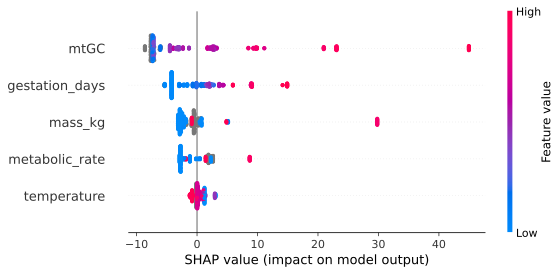

In [299]:
lifespan_no_genes.plot(save=locations.output.plots / "life_history_no_genes"  / "no_genes_summary.svg")

min_max dataset values: (3.3, 122.5)


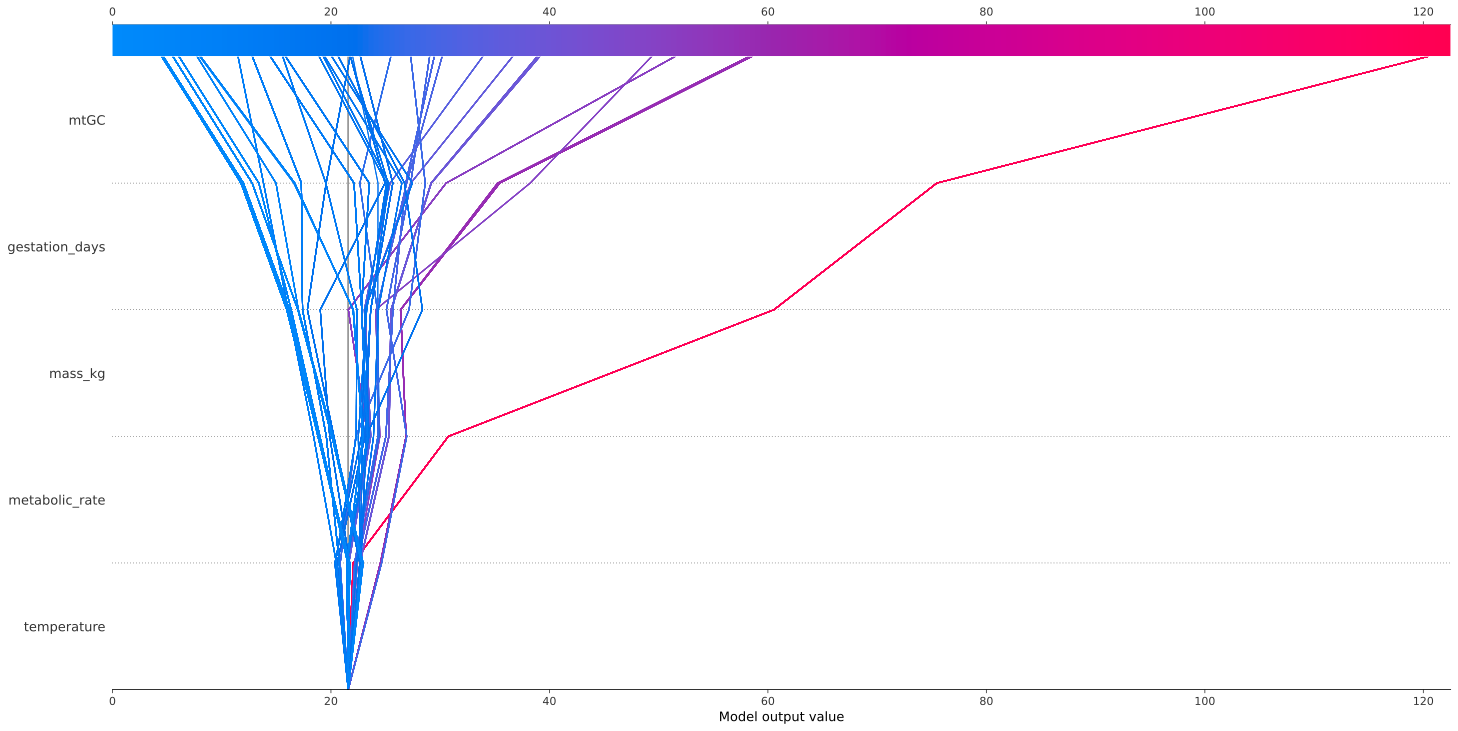

In [298]:
lifespan_no_genes.plot_decision(save=locations.output.plots / "life_history_no_genes" / "no_genes_decision.svg", auto_size_plot=False)

min_max dataset values: (3.3, 122.5)


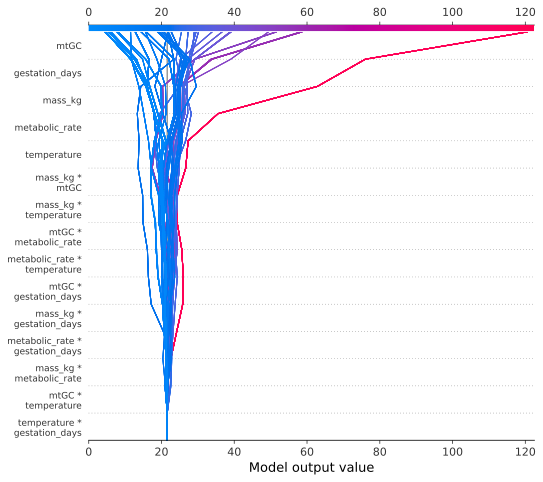

In [300]:
lifespan_no_genes.plot_interaction_decision_plot(save=locations.output.plots / "life_history_no_genes"  / "no_genes_interactions_decision.svg")

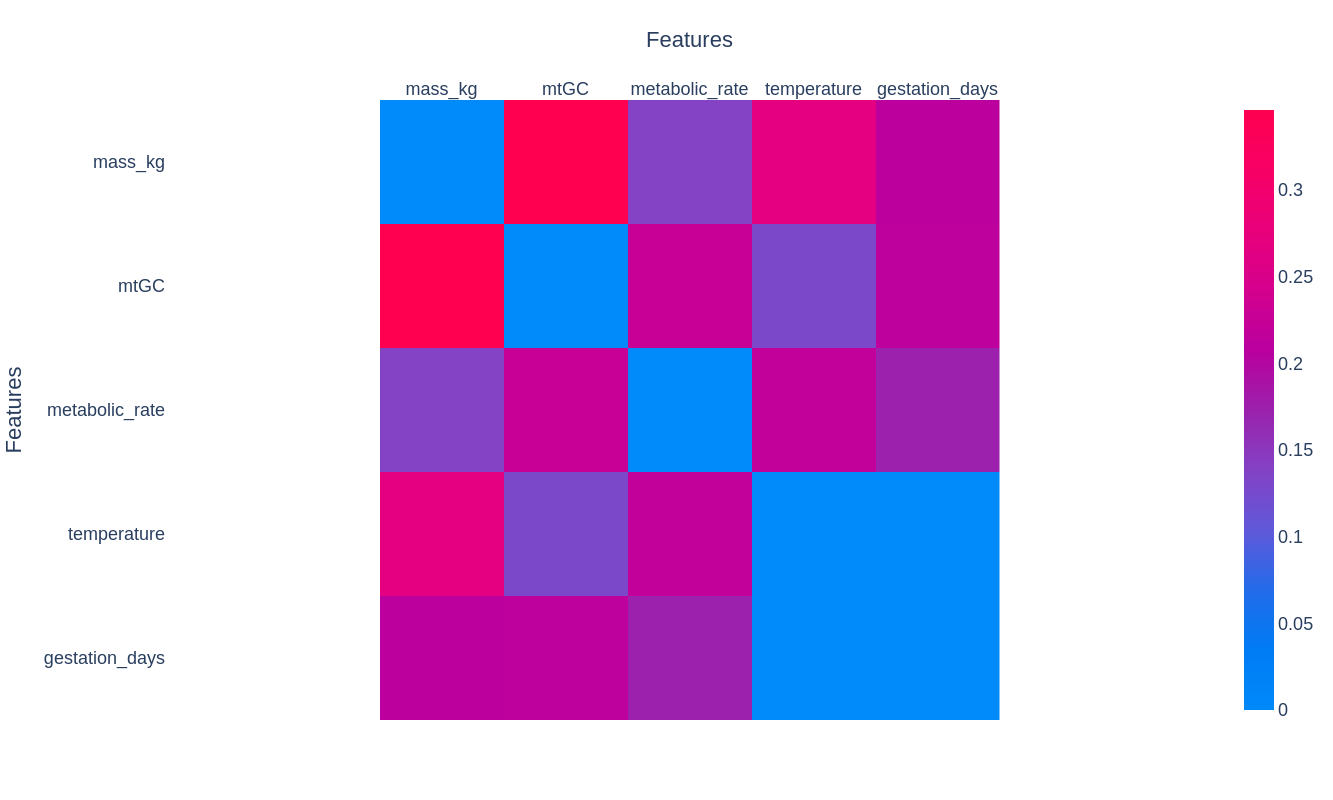

In [257]:
lifespan_no_genes.plot_interactions(height=800, width=900, max=15, title="", axis_title="Features")

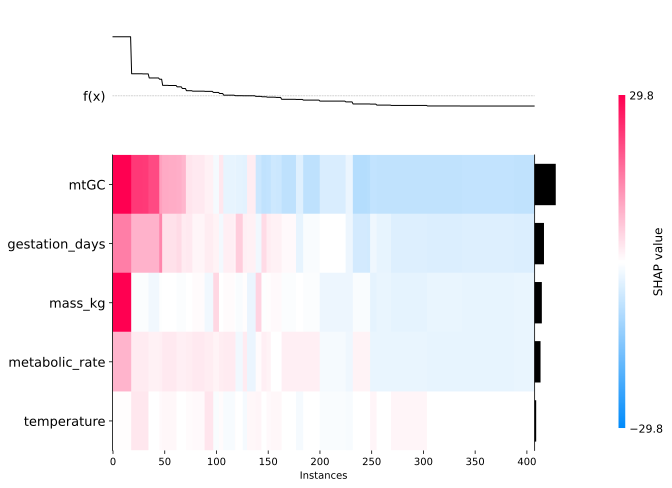

In [309]:
lifespan_no_genes.plot_heatmap(True, max_display = 7, figsize = (15,8), sort_by_clust=False, save=locations.output.plots / "life_history_no_genes" / "no_genes_heatmap_unclustered.svg")

## selection with both genes and lifehistory traits ##

In [277]:
lifespan_results_his = life_pipe.fit_transform((data,life_history_selection))
lifespan_results_his.selected

2020-11-11 01:11:57.688 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-11 01:11:57.690 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-11-11 01:11:57.695 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:12:34.865 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Early stopping, best iteration is:
[183]	valid_0's l1: 2.87243	valid_0's l2: 24.4723	valid_0's huber: 2.29571
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:12:57.038 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Early stopping, best iteration is:
[113]	valid_0's l1: 1.65541	valid_0's l2: 8.07527	valid_0's huber: 1.20747
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:13:12.135 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Early stopping, best iteration is:
[66]	valid_0's l1: 3.94283	valid_0's l2: 47.79	valid_0's huber: 3.1641
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:13:42.929 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


Early stopping, best iteration is:
[165]	valid_0's l1: 1.75754	valid_0's l2: 12.8683	valid_0's huber: 1.29206
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's l1: 1.86885	valid_0's l2: 10.4949	valid_0's huber: 1.40385


2020-11-11 01:14:28.386 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9704712902142256, MAE=2.4194111125247115, MSE=20.740172995657325, huber=1.8453167273090414)
2020-11-11 01:14:28.394 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-11 01:14:28.395 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-11 01:14:28.399 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:14:59.274 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Early stopping, best iteration is:
[153]	valid_0's l1: 2.60501	valid_0's l2: 20.8285	valid_0's huber: 2.05387
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:15:29.958 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[157]	valid_0's l1: 1.88651	valid_0's l2: 19.3813	valid_0's huber: 1.4302
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:16:06.832 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Early stopping, best iteration is:
[194]	valid_0's l1: 0.948369	valid_0's l2: 2.81547	valid_0's huber: 0.589642
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:16:53.077 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 1.52362	valid_0's l2: 7.94545	valid_0's huber: 1.09327
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 1.52362	valid_0's l2: 7.94545	valid_0's huber: 1.09327
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[212]	valid_0's l1: 1.05963	valid_0's l2: 7.09705	valid_0's huber: 0.719986


2020-11-11 01:18:15.861 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.983620608280973, MAE=1.6046278338556779, MSE=11.61355137441583, huber=1.176203394506871)
2020-11-11 01:18:15.868 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-11 01:18:15.869 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-11 01:18:15.873 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lig

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:19:20.362 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Early stopping, best iteration is:
[172]	valid_0's l1: 1.90514	valid_0's l2: 11.0799	valid_0's huber: 1.39616
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:20:08.506 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[114]	valid_0's l1: 2.51283	valid_0's l2: 20.6208	valid_0's huber: 1.94083
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:21:11.502 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Early stopping, best iteration is:
[161]	valid_0's l1: 2.98611	valid_0's l2: 38.8256	valid_0's huber: 2.38009
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:21:46.013 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


Early stopping, best iteration is:
[87]	valid_0's l1: 3.68613	valid_0's l2: 34.2663	valid_0's huber: 2.97029
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 5.17618	valid_0's l2: 72.2103	valid_0's huber: 4.28951


2020-11-11 01:22:18.390 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9464845519971291, MAE=3.2532772424361136, MSE=35.40056492127102, huber=2.537109992154486)
2020-11-11 01:22:18.398 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-11 01:22:18.399 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-11 01:22:18.403 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgb

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:23:22.938 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[159]	valid_0's l1: 1.90508	valid_0's l2: 9.93747	valid_0's huber: 1.41658
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:24:45.054 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Early stopping, best iteration is:
[209]	valid_0's l1: 2.0136	valid_0's l2: 9.6164	valid_0's huber: 1.51809
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:25:05.106 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Early stopping, best iteration is:
[44]	valid_0's l1: 5.93201	valid_0's l2: 114.912	valid_0's huber: 4.94598
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:25:55.172 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


Early stopping, best iteration is:
[126]	valid_0's l1: 1.23197	valid_0's l2: 4.47511	valid_0's huber: 0.794746
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[126]	valid_0's l1: 1.04759	valid_0's l2: 3.66359	valid_0's huber: 0.664554


2020-11-11 01:26:55.780 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9616316156534233, MAE=2.4260505703782345, MSE=28.5208339619659, huber=1.7688206995540248)
2020-11-11 01:26:55.790 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-11 01:26:55.793 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-11 01:26:55.798 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lig

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:27:59.281 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Early stopping, best iteration is:
[166]	valid_0's l1: 1.42017	valid_0's l2: 5.78181	valid_0's huber: 0.976774
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:29:19.853 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Early stopping, best iteration is:
[208]	valid_0's l1: 1.82193	valid_0's l2: 10.2544	valid_0's huber: 1.35019
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:30:29.683 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[178]	valid_0's l1: 2.64484	valid_0's l2: 20.4745	valid_0's huber: 2.09575
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:31:59.202 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


[250]	valid_0's l1: 2.97996	valid_0's l2: 27.2006	valid_0's huber: 2.39253
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 2.97993	valid_0's l2: 27.2061	valid_0's huber: 2.39261
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's l1: 2.95529	valid_0's l2: 42.568	valid_0's huber: 2.40792


2020-11-11 01:33:00.018 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9682449367380738, MAE=2.3644307846662285, MSE=21.25696232249378, huber=1.8412103035163887)
2020-11-11 01:33:00.028 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-11 01:33:00.029 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-11 01:33:00.033 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:34:05.715 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Early stopping, best iteration is:
[164]	valid_0's l1: 1.95012	valid_0's l2: 12.766	valid_0's huber: 1.47061
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:34:58.394 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[126]	valid_0's l1: 1.45814	valid_0's l2: 5.33474	valid_0's huber: 1.02945
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:35:37.554 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[89]	valid_0's l1: 3.48925	valid_0's l2: 38.827	valid_0's huber: 2.81043
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:36:30.608 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[132]	valid_0's l1: 2.47605	valid_0's l2: 24.3973	valid_0's huber: 1.96054
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[128]	valid_0's l1: 1.36164	valid_0's l2: 5.3341	valid_0's huber: 0.943455


2020-11-11 01:37:42.769 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9763007067122171, MAE=2.1470402616335207, MSE=17.331847637663884, huber=1.6348037515476708)
2020-11-11 01:37:42.778 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-11 01:37:42.780 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-11 01:37:42.784 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
/data/miniconda3/envs/yspecies/lib/python3.8/sit

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:38:50.380 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Early stopping, best iteration is:
[165]	valid_0's l1: 1.54151	valid_0's l2: 7.88528	valid_0's huber: 1.117
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:39:39.279 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Early stopping, best iteration is:
[126]	valid_0's l1: 1.62207	valid_0's l2: 7.23153	valid_0's huber: 1.18021
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:40:49.731 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Early stopping, best iteration is:
[182]	valid_0's l1: 1.20003	valid_0's l2: 8.16562	valid_0's huber: 0.839435
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:41:40.766 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


Early stopping, best iteration is:
[127]	valid_0's l1: 3.081	valid_0's l2: 22.2741	valid_0's huber: 2.47186
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's l1: 2.11005	valid_0's l2: 23.8613	valid_0's huber: 1.64809


2020-11-11 01:42:48.057 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9794508391696439, MAE=1.9109312174779927, MSE=13.883563455269515, huber=1.4476764803215636)
2020-11-11 01:42:48.067 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-11 01:42:48.069 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-11 01:42:48.075 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:43:43.634 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Early stopping, best iteration is:
[133]	valid_0's l1: 3.25368	valid_0's l2: 23.39	valid_0's huber: 2.60231
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:45:15.410 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Early stopping, best iteration is:
[230]	valid_0's l1: 2.03317	valid_0's l2: 12.9047	valid_0's huber: 1.55547
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:46:36.514 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Early stopping, best iteration is:
[200]	valid_0's l1: 1.4967	valid_0's l2: 7.10945	valid_0's huber: 1.07026
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:48:11.358 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


[250]	valid_0's l1: 2.13956	valid_0's l2: 14.4412	valid_0's huber: 1.66024
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 2.13942	valid_0's l2: 14.4403	valid_0's huber: 1.6601
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 3.08126	valid_0's l2: 35.691	valid_0's huber: 2.41395


2020-11-11 01:48:58.013 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9725582030761046, MAE=2.400846263143713, MSE=18.707076504102442, huber=1.8386354388838306)
2020-11-11 01:48:58.022 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-11 01:48:58.024 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-11 01:48:58.028 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:49:57.562 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Early stopping, best iteration is:
[150]	valid_0's l1: 1.52265	valid_0's l2: 8.39424	valid_0's huber: 1.10117
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:50:33.101 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Early stopping, best iteration is:
[85]	valid_0's l1: 2.48779	valid_0's l2: 23.9868	valid_0's huber: 1.92259
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:52:04.665 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Early stopping, best iteration is:
[228]	valid_0's l1: 1.78104	valid_0's l2: 13.3923	valid_0's huber: 1.31263
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:52:31.624 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


Early stopping, best iteration is:
[65]	valid_0's l1: 3.45013	valid_0's l2: 53.9408	valid_0's huber: 2.74703
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's l1: 2.68424	valid_0's l2: 24.2635	valid_0's huber: 2.04434


2020-11-11 01:53:11.333 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9625968937494156, MAE=2.385170221574992, MSE=24.795531907181065, huber=1.7611209527125218)
2020-11-11 01:53:11.342 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-11 01:53:11.343 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.4542347417151458, 'boosting_type': 'gbdt', 'drop_rate': 0.1249076723522795, 'feature_fraction': 0.4306998732610047, 'lambda_l1': 0.44419815002637947, 'lambda_l2': 0.050656952798591996, 'learning_rate': 0.05298955871762984, 'max_depth': 3, 'max_leaves': 25, 'min_data_in_leaf': 3, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-11 01:53:11.349 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
/data/miniconda3/envs/yspecies/lib/python3.8/site-pack

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:54:22.582 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[182]	valid_0's l1: 1.75915	valid_0's l2: 12.0996	valid_0's huber: 1.31131
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:54:57.806 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Early stopping, best iteration is:
[84]	valid_0's l1: 3.86558	valid_0's l2: 53.1297	valid_0's huber: 3.15248
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:56:09.654 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Early stopping, best iteration is:
[196]	valid_0's l1: 2.35887	valid_0's l2: 15.1638	valid_0's huber: 1.81274
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-11 01:57:13.004 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


Early stopping, best iteration is:
[156]	valid_0's l1: 2.22252	valid_0's l2: 17.9103	valid_0's huber: 1.70652
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	valid_0's l1: 1.55421	valid_0's l2: 7.76785	valid_0's huber: 1.1069


2020-11-11 01:58:20.175 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9719876423795224, MAE=2.3520683584652025, MSE=21.214238352292895, huber=1.8073005836115086)


symbol  repeats  mean_abs_shap  mean_kendall_tau  shap_0  \
ENSG00000167515  TRAPPC2L   10.000          1.113            -0.304   1.516   
ENSG00000010219     DYRK4   10.000          0.887             0.383   1.353   
ENSG00000170835       CEL   10.000          0.730             0.788   0.796   
ENSG00000204498   NFKBIL1   10.000          0.694            -0.458   1.086   
ENSG00000105672      ETV2   10.000          0.490             0.646   0.654   
ENSG00000106554    CHCHD3   10.000          0.487            -0.421   0.707   
ENSG00000066926      FECH   10.000          0.290            -0.526   0.228   
ENSG00000165501      LRR1   10.000          0.215             0.676   0.314   
ENSG00000135845      PIGC   10.000          0.183             0.099   0.133   
ENSG00000142541    RPL13A   10.000          0.180            -0.094   0.141   
ENSG00000013288    MAN2B2   10.000          0.175            -0.380   0.163   
ENSG00000102265     TIMP1   10.000          0.165             0.662   0.076   
ENSG00000142002      DPP9   10.000          0.156            -0.590   0.235   
ENSG00000144451    SPAG16   10.000          0.123             0.559   0.090   
ENSG00000183864      TOB2   10.000          0.118             0.083   0.137   
ENSG00000165555   NOXRED1   10.000          0.115             0.782   0.122   
ENSG00000136436  CALCOCO2   10.000          0.111             0.787   0.146   
ENSG00000023191      RNH1   10.000          0.092            -0.458   0.062   
ENSG00000143443   C1orf56   10.000          0.089             0.694   0.079   
ENSG00000120992    LYPLA1   10.000          0.056            -0.512   0.134   
ENSG00000053372     MRTO4   10.000          0.036            -0.342   0.039   
ENSG00000187840  EIF4EBP1   10.000          0.027             0.116   0.019   
ENSG00000066923     STAG3    9.000          0.247             0.396   0.305   
ENSG00000136942     RPL35    9.000          0.241            -0.296   0.170   
ENSG00000134489      HRH4    9.000          0.166             0.611   0.394   
ENSG00000188322      SBK1    9.000          0.083            -0.657   0.091   
ENSG00000168569   TMEM223    9.000          0.081            -0.005   0.152   
ENSG00000140398     NEIL1    9.000          0.080             0.695   0.058   
ENSG00000198870    STKLD1    9.000          0.057             0.498   0.033   
ENSG00000132432    SEC61G    9.000          0.056            -0.696   0.041   
ENSG00000100220      RTCB    9.000          0.046            -0.617   0.045   
ENSG00000204954  C12orf73    9.000          0.031             0.009   0.041   
ENSG00000185880    TRIM69    8.000          0.238             0.259   0.338   
ENSG00000092529     CAPN3    8.000          0.185             0.573   0.213   
ENSG00000132436    FIGNL1    8.000          0.154             0.561   0.241   
ENSG00000182612   TSPAN10    8.000          0.119             0.484     nan   
ENSG00000137411     VARS2    8.000          0.107            -0.660   0.127   
ENSG00000162959     MEMO1    8.000          0.107            -0.545   0.058   
ENSG00000164879       CA3    8.000          0.070            -0.599   0.139   
ENSG00000164362      TERT    8.000          0.064            -0.614   0.085   
ENSG00000122034     GTF3A    8.000          0.060             0.292     nan   
ENSG00000105131     EPHX3    8.000          0.027            -0.420   0.042   
ENSG00000189043    NDUFA4    8.000          0.015            -0.050   0.021   
ENSG00000169857      AVEN    8.000          0.015            -0.517   0.026   
ENSG00000166562    SEC11C    8.000          0.010             0.143   0.005   
ENSG00000198663   C6orf89    7.000          0.084            -0.741   0.084   
ENSG00000137343     ATAT1    7.000          0.079            -0.523     nan   
ENSG00000152705  CATSPER3    7.000          0.063             0.543     nan   
ENSG00000160948     VPS28    7.000          0.056            -0.590   0.091   
ENSG00000171121    KCNMB3    7.000          0.053             0.645  

In [280]:
print(lifespan_results_his.metrics_average)
lifespan_results_his.plot(title = "second stage lifespan model", max_display=50, plot_size=0.3, save=locations.output.plots / "life_history" / "with_genes" / "with_genes_summary.svg")

Metrics(R2=0.9693347287970729, MAE=2.3263853866156383, MSE=21.34643434323137, huber=1.7658198324117909)


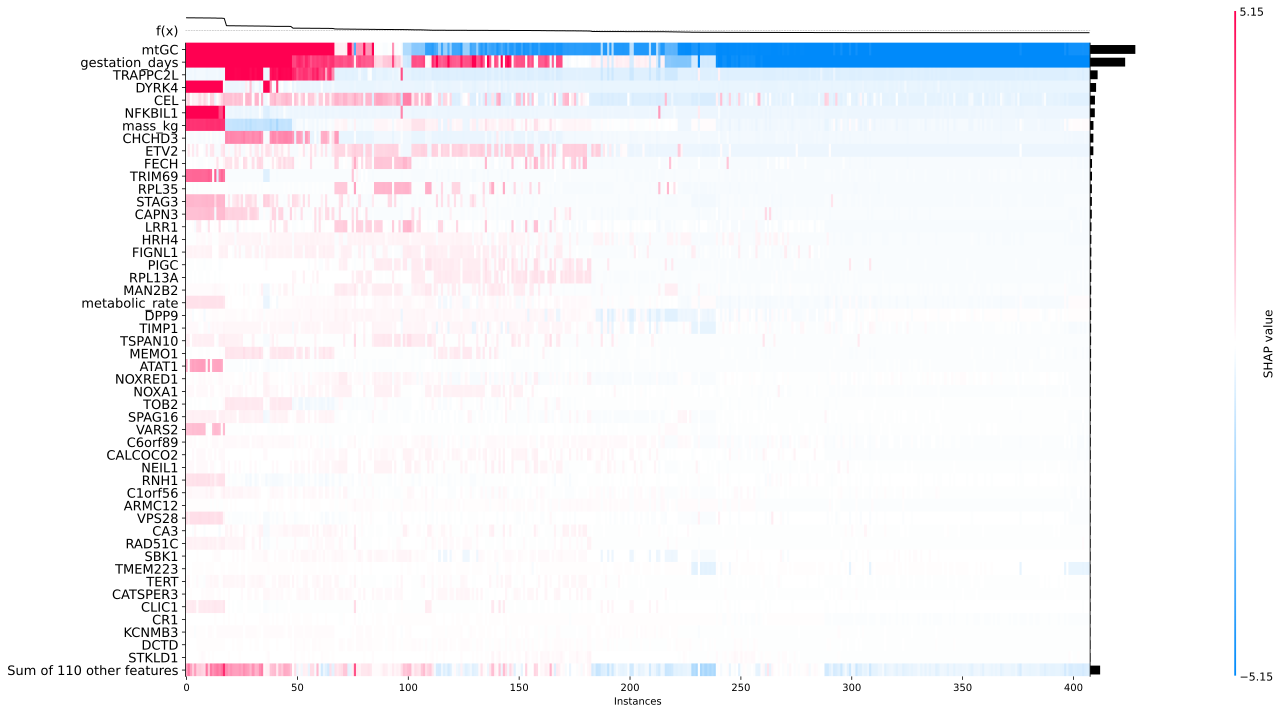

In [282]:
lifespan_results_his.plot_heatmap(True, max_display = 50, figsize = (24,12), sort_by_clust=False,  save=locations.output.plots / "life_history" / "with_genes" / "with_genes_heatmap_unclustered.svg")

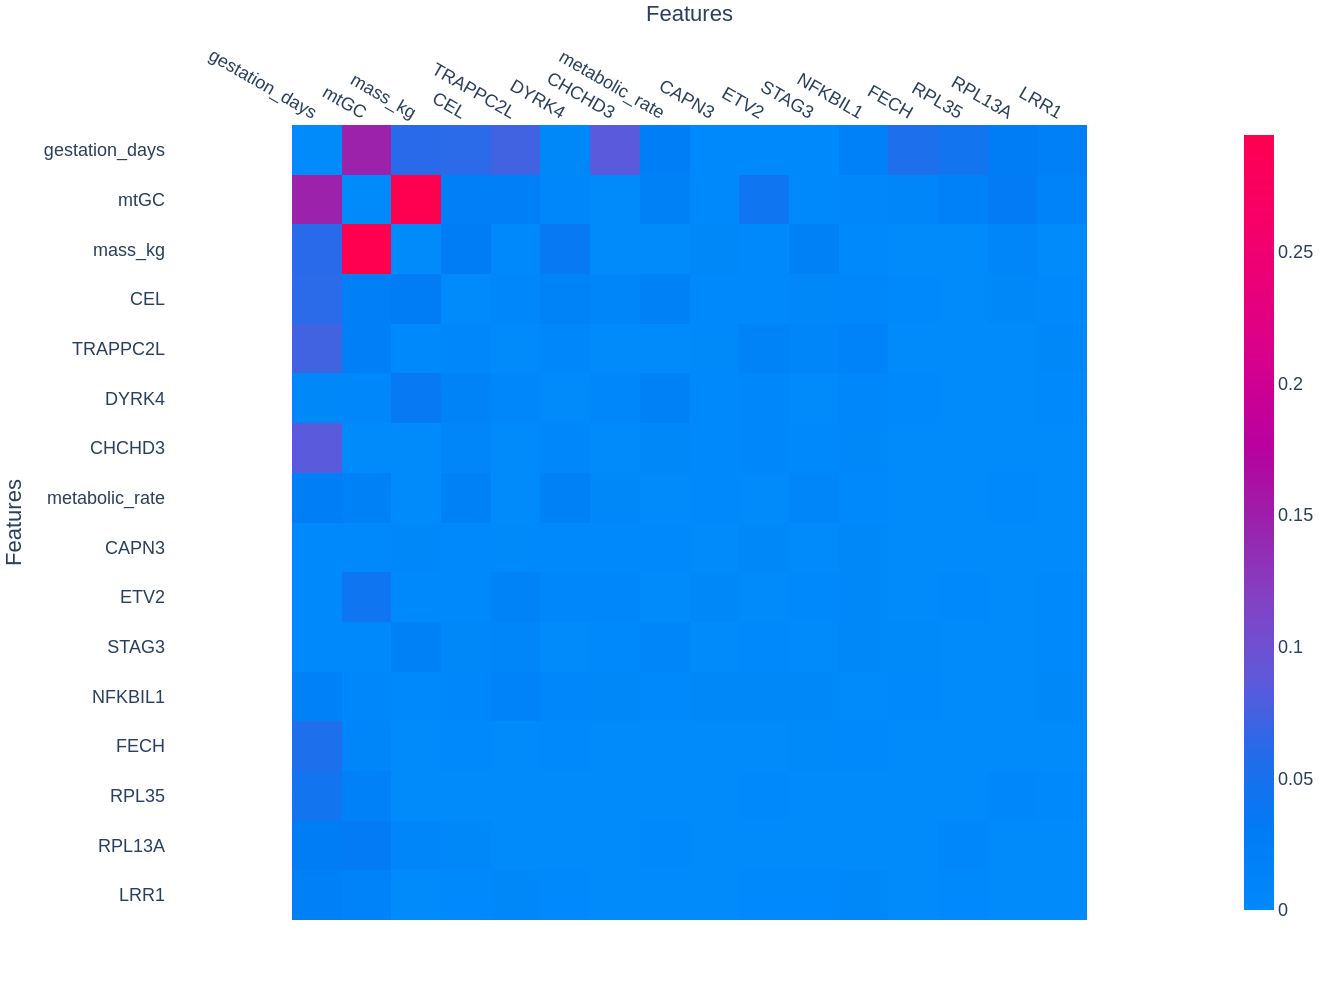

In [283]:
lifespan_results_his.plot_interactions(height=1000, width=1090, max=15, title="", axis_title="Features")

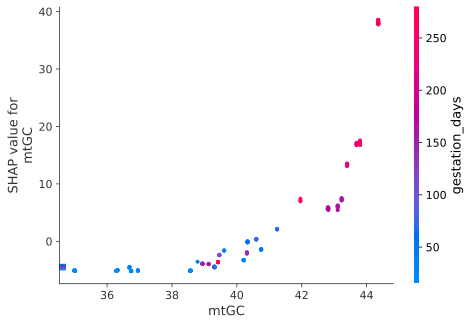

In [285]:
lifespan_results_his.plot_dependency("mtGC", save=locations.output.plots / "life_history" / "with_genes" / "mtGC_gestation_days.svg")

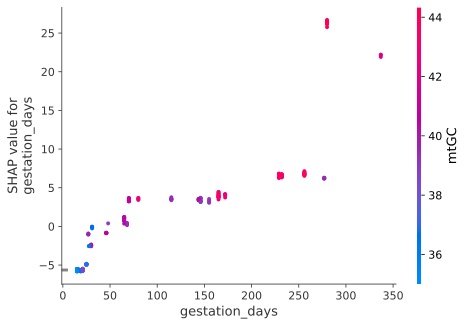

In [287]:
lifespan_results_his.plot_dependency("gestation_days", "mtGC", save=locations.output.plots / "life_history" / "with_genes" / "gestation_days_mtGC.svg")

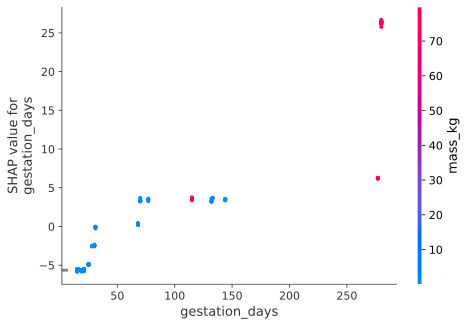

In [288]:
lifespan_results_his.plot_dependency("gestation_days", "mass_kg", save=locations.output.plots / "life_history" / "with_genes" / "gestation_days_mass_kg.svg")

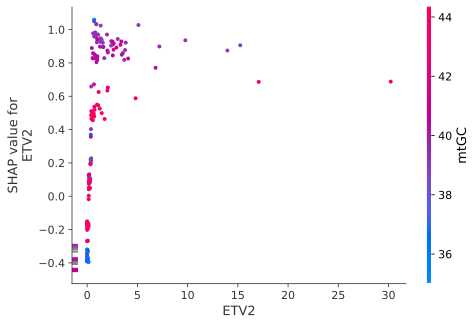

In [290]:
lifespan_results_his.plot_dependency("ETV2", "mtGC", save=locations.output.plots / "life_history" / "with_genes" / "ETV2_mtGC.svg")

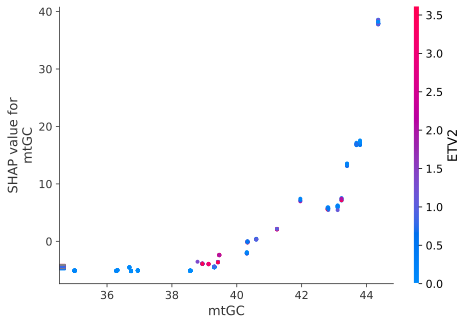

In [291]:
lifespan_results_his.plot_dependency("mtGC","ETV2", save=locations.output.plots / "life_history" / "with_genes" / "mtGC_ETV2.svg")